In [1]:
import pandas as pd
import numpy as np
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, learning_curve

import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

CLASS_LABELS = {0: "Not Profitable at All",
     1: "Not Profitable",
     2: "Neutral",
     3: "Profitable",
     4: "Very Profitable" 
}

- Data loads in 3.67 seconds

In [43]:
train = pd.read_feather('./ml_data/2017train.feather')
dev = pd.read_feather('./ml_data/2018dev.feather')
X_test = pd.read_feather('./ml_data/2019test.feather').drop('index', axis=1)

In [44]:
len(train), len(dev), len(X_test)

(26999747, 23820598, 15538830)

In [5]:
X_train = train[['PULocationID', 'dow', 'hour', 'tmpc', 'heavy_snow', 'snow']]
y_train = train['label']

X_dev = dev[['PULocationID', 'dow', 'hour', 'tmpc', 'heavy_snow', 'snow']]
y_dev = dev['label']

In [6]:
display(y_train.value_counts())
display(y_dev.value_counts())

0    5399954
4    5399950
2    5399950
3    5399948
1    5399945
Name: label, dtype: int64

3    4764120
2    4764120
0    4764120
4    4764119
1    4764119
Name: label, dtype: int64

In [3]:
def reporter(y_dev, y_pred):
    print(classification_report(y_dev, y_pred))
    print(f'Classification Accuracy: {100*accuracy_score(y_pred, y_dev):.2f}%')

    df = pd.DataFrame(confusion_matrix(y_dev, y_pred))
    fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))
    sns.heatmap(df, annot=True, fmt='d', ax=ax)
    plt.ylim(-1, 5)
    plt.xlim(-1, 5)
    plt.show()

### Baseline Classifier - OneR
- 1 minute 10 seconds (laptop)
- 47.8 seconds (desktop)
- 28.97%

              precision    recall  f1-score   support

           0       0.51      0.53      0.52   4764120
           1       0.00      0.00      0.00   4764119
           2       0.00      0.00      0.00   4764120
           3       0.23      0.93      0.37   4764120
           4       0.00      0.00      0.00   4764119

    accuracy                           0.29  23820598
   macro avg       0.15      0.29      0.18  23820598
weighted avg       0.15      0.29      0.18  23820598

Classification Accuracy: 29.25%


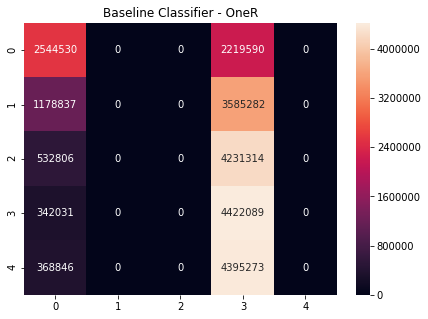

In [8]:
oneR = DecisionTreeClassifier(random_state=0, max_depth=1).fit(X_train, y_train)
oneR_pred = oneR.predict(X_dev)

print(classification_report(y_dev, oneR_pred))
print(f'Classification Accuracy: {100*accuracy_score(oneR_pred, y_dev):.2f}%')

df = pd.DataFrame(confusion_matrix(y_dev, oneR_pred))

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.heatmap(df, annot=True, fmt='d', ax=ax)

plt.title("Baseline Classifier - OneR")

plt.show()

### Decision Tree Classifier
- 1 minute 44 seconds (laptop)
- 1 minute 13 seconds (desktop)
- 44.96%

              precision    recall  f1-score   support

           0       0.81      0.48      0.61   4764120
           1       0.42      0.44      0.43   4764119
           2       0.28      0.37      0.32   4764120
           3       0.37      0.38      0.38   4764120
           4       0.56      0.57      0.56   4764119

    accuracy                           0.45  23820598
   macro avg       0.49      0.45      0.46  23820598
weighted avg       0.49      0.45      0.46  23820598

Classification Accuracy: 44.96%


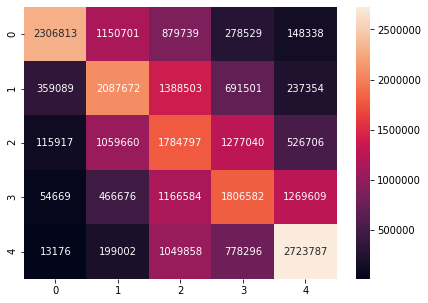

In [28]:
clf = DecisionTreeClassifier(random_state=0, min_impurity_decrease = 0, max_depth = 5).fit(X_train, y_train)
y_pred = clf.predict(X_dev)

export_graphviz(clf, out_file = 'treeInitial.dot',
                                 feature_names=X_train.columns, filled   = True
                                    , rounded  = True
                                    , special_characters = True)

print(classification_report(y_dev, y_pred))
print(f'Classification Accuracy: {100*accuracy_score(y_pred, y_dev):.2f}%')

df = pd.DataFrame(confusion_matrix(y_dev, y_pred))

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.heatmap(df, annot=True, fmt='d', ax=ax)


plt.show()

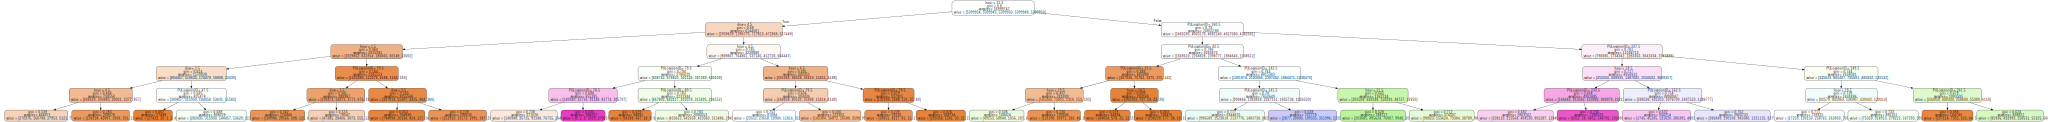

In [29]:
with open("./treeInitial.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

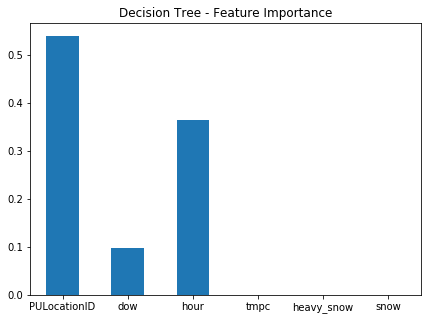

In [11]:
# The sum of this should be 1
features = pd.DataFrame(clf.feature_importances_)
features.index = ['PULocationID', 'dow', 'hour', 'tmpc', 'heavy_snow', 'snow']

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7, 5))
features.plot.bar(legend=False, ax=ax)

plt.title("Decision Tree - Feature Importance")
plt.xticks(rotation=0)

plt.show()

### Random Forest Classifier
- 
- 7 minutes 17 seconds (desktop)
- 41.99%

              precision    recall  f1-score   support

           0       0.61      0.60      0.60   4764120
           1       0.46      0.27      0.34   4764119
           2       0.30      0.42      0.35   4764120
           3       0.38      0.17      0.23   4764120
           4       0.41      0.64      0.50   4764119

    accuracy                           0.42  23820598
   macro avg       0.43      0.42      0.40  23820598
weighted avg       0.43      0.42      0.40  23820598

Classification Accuracy: 41.99%


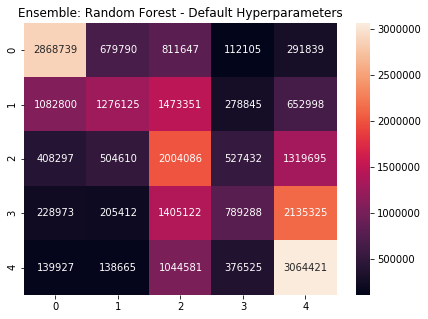

In [12]:
clf = RandomForestClassifier(n_estimators=50, random_state=0, min_samples_leaf = 1000, max_depth = 5).fit(X_train, y_train)
y_pred = clf.predict(X_dev)

print(classification_report(y_dev, y_pred))
print(f'Classification Accuracy: {100*accuracy_score(y_pred, y_dev):.2f}%')

df = pd.DataFrame(confusion_matrix(y_dev, y_pred))

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.heatmap(df, annot=True, fmt='d', ax=ax)

plt.title("Ensemble: Random Forest - Default Hyperparameters")

plt.show()

### Logistic Regression 
- 10 minutes and 24 seconds (laptop)
- 6 minutes and 19 seconds (desktop)
- 30.96%

              precision    recall  f1-score   support

           0       0.41      0.58      0.48   4764120
           1       0.14      0.01      0.01   4764119
           2       0.22      0.19      0.20   4764120
           3       0.25      0.29      0.27   4764120
           4       0.27      0.39      0.32   4764119

    accuracy                           0.29  23820598
   macro avg       0.26      0.29      0.26  23820598
weighted avg       0.26      0.29      0.26  23820598

Classification Accuracy: 29.25%


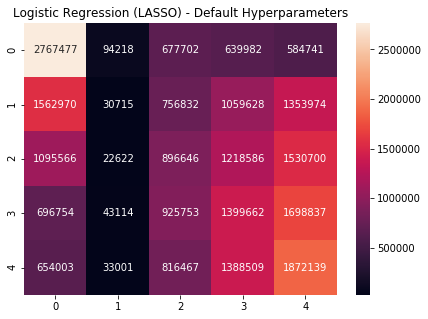

In [13]:
clf = LogisticRegression(penalty='l2', max_iter=500, n_jobs=-1, solver='lbfgs').fit(X_train, y_train)
y_pred = clf.predict(X_dev)

print(classification_report(y_dev, y_pred))
print(f'Classification Accuracy: {100*accuracy_score(y_pred, y_dev):.2f}%')

df = pd.DataFrame(confusion_matrix(y_dev, y_pred))

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.heatmap(df, annot=True, fmt='d', ax=ax)

plt.title("Logistic Regression (LASSO) - Default Hyperparameters")

plt.show()

By far, the DT seems most promising in terms of time complexity and evaluation accuracy. Although Logistic Regression seemed like a good potential model for this problem, it seems it will not improve **even** with hyperparamter tuning (which may overfit)

# Feature Engineering
- Since DTs already incooporate feature selection during their training stage, we can take evaluate the model to see whcih features it deems important

In [14]:
train.head()

,PULocationID,dow,hour,tmpc,heavy_snow,snow,label
0,48,6,0,7.0,0.0,0.0,4
1,48,6,0,7.0,0.0,0.0,4
2,48,6,0,7.0,0.0,0.0,4
3,48,6,0,7.0,0.0,0.0,3
4,48,6,0,7.0,0.0,0.0,4


In [15]:
dev.head()

,PULocationID,dow,hour,tmpc,heavy_snow,snow,label
0,41,0,0,0.0,0.0,0.0,0
1,41,0,0,-11.0,0.0,0.0,0
2,41,0,0,0.0,0.0,0.0,0
3,41,0,0,-11.0,0.0,0.0,0
4,41,0,0,0.0,0.0,0.0,0


The mutual information suggests both `heavy_snow` and `snow` have no use as a feature. This is expected since the instances are conditioned on the fact that these months have snowfall.

We can remove these attributes and just work with `PULocationID`, `dow`, `hour` and `tmpc` to see if we can reduce the noise in the data.

In [47]:
X_train = X_train[['PULocationID', 'dow', 'hour']]
X_dev =  X_dev[['PULocationID', 'dow', 'hour']]

In [7]:
def hyperparam_tune(X_train, y_train, estimator, parameters):
    # randomised search for hyperparameters
    rs = RandomizedSearchCV(estimator, parameters, n_iter=20, cv=5, random_state=0, n_jobs=-1)
    rs_fit = rs.fit(X_train, y_train)
    display(rs_fit.cv_results_)
    return rs_fit.best_params_

In [8]:
clftune = DecisionTreeClassifier(random_state=0)

param_dist = {"max_depth": [5, 15, 25, 35, None],
              "min_samples_split": [2, 5, 100, 250, 500, 1000, 5000],
              "min_samples_leaf": [2, 5, 100, 250, 500, 1000, 5000],
              "max_leaf_nodes": [5, 15, 25, 35, None],
              "criterion": ["gini", "entropy"]}

best_param = hyperparam_tune(X_train, y_train, clftune, param_dist)

{'mean_fit_time': array([26.63616986, 21.08447375, 15.78203697, 13.82208457, 18.85037594,
        13.88680224, 19.68819933, 21.25367866, 22.14442997, 28.57800145,
        22.42690578, 13.25024171, 27.10218263, 12.65154724, 23.45172482,
        27.51670079, 26.73838391, 27.46936202, 13.72403536, 16.10870109]),
 'std_fit_time': array([5.84207253, 2.845506  , 1.72152644, 0.93987148, 0.37034932,
        0.60998329, 1.46527619, 1.31353732, 1.82783212, 2.41196967,
        1.24753265, 0.8673757 , 0.54692714, 1.11687595, 1.53068654,
        1.69865077, 1.19830658, 1.47587851, 0.54582833, 1.95461862]),
 'mean_score_time': array([0.85507545, 0.74020677, 0.83155093, 0.75316138, 0.78453097,
        0.70467362, 0.74327841, 0.77923574, 0.75861068, 0.83158512,
        0.74540958, 0.64738293, 0.80669098, 0.82282567, 0.78996387,
        0.89068084, 0.80631266, 0.82745528, 0.69091353, 0.51808939]),
 'std_score_time': array([0.09238082, 0.07845828, 0.15976315, 0.12472522, 0.11016521,
        0.09738187, 

In [14]:
best_param

{'min_samples_split': 250,
 'min_samples_leaf': 5000,
 'max_leaf_nodes': None,
 'max_depth': 35,
 'criterion': 'gini',
 'random_state': 0}

              precision    recall  f1-score   support

           0       0.90      0.87      0.88   4764120
           1       0.71      0.72      0.72   4764119
           2       0.55      0.60      0.58   4764120
           3       0.58      0.58      0.58   4764120
           4       0.76      0.71      0.74   4764119

    accuracy                           0.70  23820598
   macro avg       0.70      0.70      0.70  23820598
weighted avg       0.70      0.70      0.70  23820598

Classification Accuracy: 69.63%


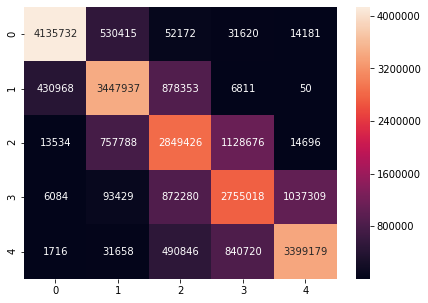

In [31]:
clf = DecisionTreeClassifier(min_samples_split= 250,
                                min_samples_leaf = 5000,
                                max_leaf_nodes = None,
                                max_depth = 35,
                                criterion = 'gini',
                                random_state = 0).fit(X_train, y_train)
y_pred = clf.predict(X_dev)

export_graphviz(clf, out_file = 'tuned.dot',
                                 feature_names=X_train.columns, filled   = True
                                    , rounded  = True
                                    , special_characters = True)

print(classification_report(y_dev, y_pred))
print(f'Classification Accuracy: {100*accuracy_score(y_pred, y_dev):.2f}%')

df = pd.DataFrame(confusion_matrix(y_dev, y_pred))

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.heatmap(df, annot=True, fmt='d', ax=ax)


plt.show()

# Tree Pruning

In [40]:
clf = DecisionTreeClassifier(min_samples_split= 250,
                                min_samples_leaf = 5000,
                                max_leaf_nodes = None,
                                max_depth = 35,
                                criterion = 'gini',
                                random_state = 0).fit(X_train, y_train)

Initial number of leaf nodes: 2669
Final number of leaf nodes: 3011


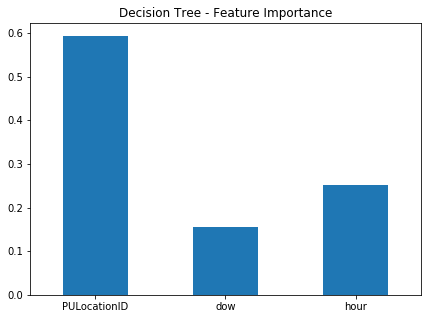

In [41]:
from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

"""
"""

print(f"Initial number of leaf nodes: {sum(clf.tree_.children_left < 0)}")
# start pruning from the root
prune_index(clf.tree_, 0, 5)
print(f"Final number of leaf nodes: {sum(clf.tree_.children_left < 0)}")

"""
"""

features = pd.DataFrame(clf.feature_importances_)
features.index = ['PULocationID', 'dow', 'hour']
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(7, 5))
features.plot.bar(legend=False, ax=ax)
plt.title("Decision Tree - Feature Importance")
plt.xticks(rotation=0)
plt.show()

"""
"""

export_graphviz(clf, out_file = 'pruned.dot',
                                 feature_names=X_train.columns, filled   = True
                                    , rounded  = True
                                    , special_characters = True)

In [ ]:
with open("./pruned.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

# Learning Curve 
- Prediction Accuracy
- Number of instances

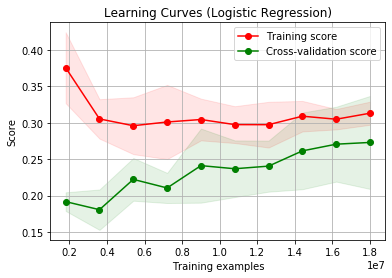

In [39]:
from sklearn.model_selection import learning_curve

clf = LogisticRegression(penalty='l2', max_iter=500, n_jobs=-1, solver='lbfgs')

title = "Learning Curves (Logistic Regression)"

plt.figure()
plt.title(title)

plt.xlabel("Training examples")
plt.ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, n_jobs=-1, train_sizes = np.linspace(.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# Predictions for 2019

In [45]:
X_test.head()

,PULocationID,hour,dow,tmpc,heavy_snow,snow
0,217,3,5,6.72,0.0,0.0
1,148,3,5,6.72,0.0,0.0
2,113,4,5,6.72,0.0,0.0
3,114,4,5,6.72,0.0,0.0
4,223,20,1,1.11,0.0,0.0


In [48]:
clf = DecisionTreeClassifier(min_samples_split= 250,
                                min_samples_leaf = 5000,
                                max_leaf_nodes = None,
                                max_depth = 35,
                                criterion = 'gini',
                                random_state = 0).fit(X_train, y_train)

In [56]:
y_pred = clf.predict(X_test[['PULocationID','hour','dow']])

In [58]:
final_preds = X_test[['PULocationID','hour','dow']].copy()
final_preds['predicted_rating'] = y_pred

In [59]:
final_preds.head()

,PULocationID,hour,dow,predicted_rating
0,41,0,0,0
1,41,0,0,0
2,41,0,0,0
3,41,0,0,0
4,41,0,0,0


In [55]:
final_preds.to_feather('./ml_data/2019predictions.feather')